In [1]:
# Import Libraries
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [15]:
# Import Data (Insert your path here)
path = '/Users/las/Documents/GitHub/REU/data_v1.csv'
df = pd.read_csv(path)
df[df.no % 2==1] = df[df.no % 2==1] + 1 
df.head()

,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,no
0,-0.226011,2.325943,-0.922747,0.865980,0.761529,0.502734,0.810792,-1.000433,-0.750675,0.730550,-2.310786,-0.573934,1.003053,-0.751558,-1.006496,0.615400,1.004403,-0.526818,38
1,-0.043590,2.116722,-0.829761,0.897924,1.322964,0.746200,0.763774,-0.491018,-0.172851,-0.510863,0.020585,0.162028,0.402611,-1.065471,-0.742174,0.325673,1.281842,-0.440535,64
2,-0.239755,2.029160,-1.448763,0.987687,0.786193,0.978660,0.472226,-0.385126,-0.322631,-0.087795,-1.216353,-0.940211,0.458661,-1.089649,-1.212046,0.658751,1.067461,-0.222628,80
3,-0.210654,1.955915,-1.833612,0.810325,0.437777,0.873906,0.290471,-0.466028,-0.115158,-0.125359,0.268939,-0.009907,0.718668,-1.019726,-0.770802,0.211152,1.288351,-0.440049,46
4,-0.991812,2.012763,-0.997473,0.438114,0.327704,0.477286,0.167688,-1.283432,0.977861,0.745067,-1.499691,0.646092,-0.278155,-0.895265,-0.477855,0.428501,0.440284,-0.099511,38


In [29]:
# Create Training and Validation Data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("no", axis=1).astype('float64')[:69500],
    df["no"][:69500]//2, 
    test_size=0.2, random_state=911)

X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)
print(f"There a {len(X_train)} training samples and {len(X_test)} test samples.")

There a 55600 training samples and 13900 test samples.


In [30]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(
        units=1000, activation='relu', input_shape=(18,),
        kernel_regularizer='l1_l2',
        bias_regularizer='l1'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units=93, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000)              19000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 93)                93093     
Total params: 1,113,093
Trainable params: 1,113,093
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Set up training
sce = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='Adam', loss=sce, metrics=['accuracy', sce])

In [32]:
# Train model
history = model.fit(
    X_train,
    y_train,
    verbose=2,
    epochs=25,
    batch_size=32,
    validation_data=(
        X_test,
        y_test
    )
)

Train on 55600 samples, validate on 13900 samples
Epoch 1/25
55600/55600 - 77s - loss: 3.4066 - accuracy: 0.1619 - sparse_categorical_crossentropy: 2.9421 - val_loss: 3.0775 - val_accuracy: 0.2331 - val_sparse_categorical_crossentropy: 2.6396
Epoch 2/25
55600/55600 - 78s - loss: 2.9320 - accuracy: 0.2760 - sparse_categorical_crossentropy: 2.5262 - val_loss: 3.6545 - val_accuracy: 0.3407 - val_sparse_categorical_crossentropy: 2.4507
Epoch 3/25
55600/55600 - 67s - loss: 2.7673 - accuracy: 0.3741 - sparse_categorical_crossentropy: 2.2356 - val_loss: 2.3490 - val_accuracy: 0.5058 - val_sparse_categorical_crossentropy: 1.8931
Epoch 4/25
55600/55600 - 66s - loss: 2.6087 - accuracy: 0.4516 - sparse_categorical_crossentropy: 2.0088 - val_loss: 2.1470 - val_accuracy: 0.5764 - val_sparse_categorical_crossentropy: 1.6723
Epoch 5/25
55600/55600 - 65s - loss: 2.3454 - accuracy: 0.5057 - sparse_categorical_crossentropy: 1.8125 - val_loss: 2.0315 - val_accuracy: 0.6006 - val_sparse_categorical_crosse

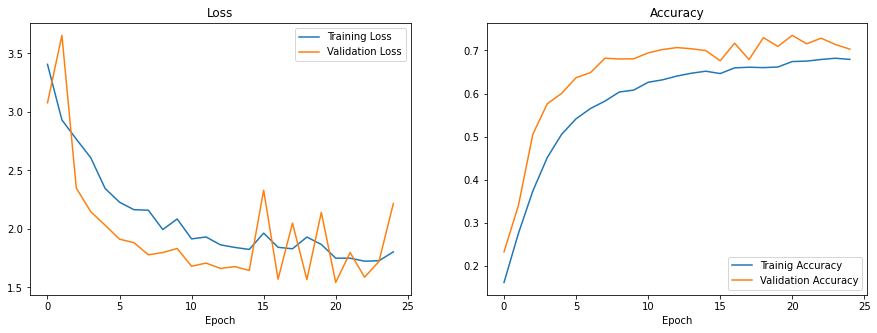

In [33]:
# Graphs
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['loss'], label="Training Loss") 
axs[0].plot(history.history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(history.history['accuracy'], label="Trainig Accuracy") 
axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")
axs[1].sharex(axs[0])

for ax in axs.flat:
    ax.set(xlabel='Epoch')
fig.savefig('tmp.png')

In [34]:
history.history['val_accuracy'][-1]

0.7030935

In [35]:
df_rs = df[50000:69500]
df_136 = df[69500:]

In [36]:
#random + hc data
df_hc = df[:50000]
predictions_hc = 2*np.argmax(model.predict(df_hc.drop('no', axis=1)), axis=1)
df_hc.insert(19, 'pred', predictions_hc)
print(f"Accuracy on all hc data {len(df_hc[df_hc.no == df_hc.pred])/50000}")
for val in sorted(set(df_hc.no)):
    print(f"n={val}: Anzahl={len(df_hc[df_hc.no==val])}  Vorhersage={len(df_hc[df_hc.pred==val])}")

Accuracy on all hc data 0.8765
n=0: Anzahl=259  Vorhersage=195
n=4: Anzahl=78  Vorhersage=79
n=6: Anzahl=16  Vorhersage=0
n=8: Anzahl=406  Vorhersage=386
n=10: Anzahl=165  Vorhersage=146
n=12: Anzahl=726  Vorhersage=749
n=14: Anzahl=517  Vorhersage=929
n=16: Anzahl=1916  Vorhersage=1709
n=18: Anzahl=714  Vorhersage=756
n=20: Anzahl=1936  Vorhersage=2286
n=22: Anzahl=1437  Vorhersage=1369
n=24: Anzahl=2192  Vorhersage=2148
n=26: Anzahl=2223  Vorhersage=1970
n=28: Anzahl=2880  Vorhersage=2915
n=30: Anzahl=1876  Vorhersage=1616
n=32: Anzahl=2174  Vorhersage=2133
n=34: Anzahl=3369  Vorhersage=3096
n=36: Anzahl=2595  Vorhersage=3095
n=38: Anzahl=3839  Vorhersage=3388
n=40: Anzahl=3669  Vorhersage=3665
n=42: Anzahl=2918  Vorhersage=2984
n=44: Anzahl=2599  Vorhersage=2720
n=46: Anzahl=2412  Vorhersage=2046
n=48: Anzahl=2134  Vorhersage=1845
n=50: Anzahl=1524  Vorhersage=1664
n=52: Anzahl=767  Vorhersage=873
n=54: Anzahl=645  Vorhersage=660
n=56: Anzahl=1497  Vorhersage=1716
n=58: Anzahl=899  

In [37]:
#random data
df_rs = df[50000:69500]
predictions_rs = 2*np.argmax(model.predict(df_rs.drop('no', axis=1)), axis=1)
df_rs.insert(19, 'pred', predictions_rs)
print(f"Accuracy on random data {len(df_rs[df_rs.no == df_rs.pred])/19500}")
for val in sorted(set(df_rs.no)):
    print(f"n={val}: Anzahl={len(df_rs[df_rs.no==val])}  Vorhersage={len(df_rs[df_rs.pred==val])}")

Accuracy on random data 0.3221538461538462
n=0: Anzahl=4578  Vorhersage=8023
n=2: Anzahl=3  Vorhersage=2
n=4: Anzahl=108  Vorhersage=41
n=6: Anzahl=134  Vorhersage=7
n=8: Anzahl=375  Vorhersage=117
n=10: Anzahl=422  Vorhersage=58
n=12: Anzahl=637  Vorhersage=493
n=14: Anzahl=730  Vorhersage=189
n=16: Anzahl=1105  Vorhersage=582
n=18: Anzahl=1174  Vorhersage=480
n=20: Anzahl=1311  Vorhersage=1560
n=22: Anzahl=1326  Vorhersage=1335
n=24: Anzahl=1273  Vorhersage=1688
n=26: Anzahl=1149  Vorhersage=804
n=28: Anzahl=1014  Vorhersage=1147
n=30: Anzahl=894  Vorhersage=365
n=32: Anzahl=813  Vorhersage=911
n=34: Anzahl=645  Vorhersage=723
n=36: Anzahl=492  Vorhersage=281
n=38: Anzahl=392  Vorhersage=139
n=40: Anzahl=306  Vorhersage=93
n=42: Anzahl=231  Vorhersage=174
n=44: Anzahl=135  Vorhersage=69
n=46: Anzahl=96  Vorhersage=57
n=48: Anzahl=56  Vorhersage=39
n=50: Anzahl=40  Vorhersage=38
n=52: Anzahl=27  Vorhersage=44
n=54: Anzahl=14  Vorhersage=7
n=56: Anzahl=9  Vorhersage=24
n=58: Anzahl=7  

In [38]:
#136 data
df_136 = df[69500:-1]
predictions_136 = 2*np.argmax(model.predict(df_136.drop('no', axis=1)), axis=1)
df_136.insert(19, 'pred', predictions_136)
print(f"Accuracy on 136 data {len(df_136[df_136.no == df_136.pred])/5500}")

Accuracy on 136 data 0.0001818181818181818


In [39]:
for val in sorted(set(df_136.no)):
    print(f"n={val}: Anzahl={len(df_136[df_136.no==val])}  Vorhersage={len(df_136[df_136.pred==val])}")

n=0: Anzahl=1  Vorhersage=0
n=32: Anzahl=629  Vorhersage=0
n=40: Anzahl=373  Vorhersage=0
n=42: Anzahl=18  Vorhersage=0
n=44: Anzahl=16  Vorhersage=0
n=46: Anzahl=17  Vorhersage=0
n=48: Anzahl=1574  Vorhersage=28
n=64: Anzahl=416  Vorhersage=0
n=66: Anzahl=44  Vorhersage=0
n=68: Anzahl=29  Vorhersage=0
n=70: Anzahl=56  Vorhersage=0
n=72: Anzahl=482  Vorhersage=0
n=74: Anzahl=31  Vorhersage=0
n=76: Anzahl=23  Vorhersage=0
n=78: Anzahl=19  Vorhersage=0
n=80: Anzahl=1025  Vorhersage=0
n=82: Anzahl=2  Vorhersage=0
n=104: Anzahl=25  Vorhersage=0
n=106: Anzahl=14  Vorhersage=0
n=108: Anzahl=24  Vorhersage=0
n=110: Anzahl=18  Vorhersage=0
n=112: Anzahl=211  Vorhersage=0
n=114: Anzahl=80  Vorhersage=0
n=116: Anzahl=30  Vorhersage=0
n=118: Anzahl=10  Vorhersage=0
n=120: Anzahl=11  Vorhersage=0
n=122: Anzahl=19  Vorhersage=0
n=124: Anzahl=26  Vorhersage=0
n=126: Anzahl=59  Vorhersage=0
n=128: Anzahl=187  Vorhersage=0
n=130: Anzahl=17  Vorhersage=0
n=132: Anzahl=11  Vorhersage=0
n=134: Anzahl=2  